In [ ]:
from google.colab import drive
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split
import random


# Data Preprocessing

### Data Import

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the zipped file in Google Drive
zip_file_path = '/content/drive/MyDrive/PoribohonBD.zip'

# Extract the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

Mounted at /content/drive


### Creating Train, Validation, & Test Set

In [ ]:
# Define paths
dataset_path = '/content/PoribohonBD'
train_path = '/content/train'
val_path = '/content/validation'
test_path = '/content/test'

# Create directories for train, validation, and test sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get the list of sub-folders (vehicle classes)
class_names = os.listdir(dataset_path)

# Iterate over each class folder
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Shuffle the images
    random.shuffle(images)

    # Split the images into train, validation, and test sets
    train_images, test_val_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    # Create class directories in train, validation, and test sets
    train_class_path = os.path.join(train_path, class_name)
    val_class_path = os.path.join(val_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Move images to respective directories
    for image in train_images:
        shutil.move(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.move(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.move(os.path.join(class_path, image), os.path.join(test_class_path, image))

# Verify the structure of the directories
print("Train set:", os.listdir(train_path))
print("Validation set:", os.listdir(val_path))
print("Test set:", os.listdir(test_path))


Train set: ['Launch', 'Car', 'Bus', 'Boat', 'Tractor', 'Wheelbarrow', 'Van', 'Cng', 'Bicycle', 'Leguna', 'Easy-bike', 'Rickshaw', 'Bike', 'Horse-cart', 'Truck']
Validation set: ['Launch', 'Car', 'Bus', 'Boat', 'Tractor', 'Wheelbarrow', 'Van', 'Cng', 'Bicycle', 'Leguna', 'Easy-bike', 'Rickshaw', 'Bike', 'Horse-cart', 'Truck']
Test set: ['Launch', 'Car', 'Bus', 'Boat', 'Tractor', 'Wheelbarrow', 'Van', 'Cng', 'Bicycle', 'Leguna', 'Easy-bike', 'Rickshaw', 'Bike', 'Horse-cart', 'Truck']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 6504 files belonging to 15 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 813 files belonging to 15 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 821 files belonging to 15 classes.


Show the first nine images and labels from the training set:

['Bicycle', 'Bike', 'Boat', 'Bus', 'Car', 'Cng', 'Easy-bike', 'Horse-cart', 'Launch', 'Leguna', 'Rickshaw', 'Tractor', 'Truck', 'Van', 'Wheelbarrow']
tf.Tensor(
[12  2  5 12  8  0 10  6  6  2  1  2  3 10  6  8  4  4  8  2 13 13  5  1
 11  3  0 12  0  9  0  7], shape=(32,), dtype=int32)


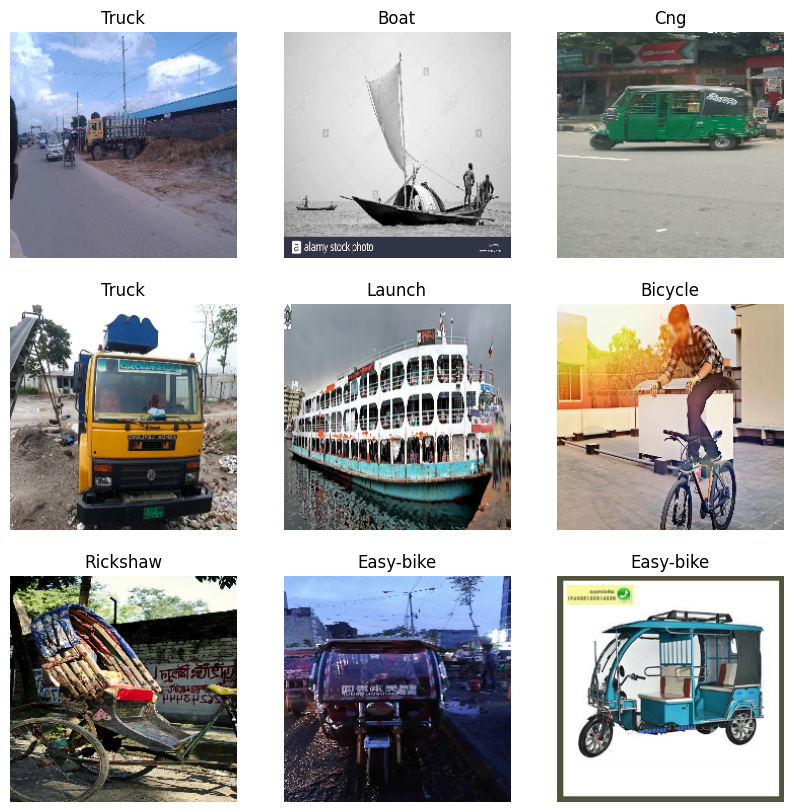

In [ ]:
class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  print(labels)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Define & Apply One-Hot Encoding to the Datasets

In [ ]:
num_classes = len(class_names)

# Define a helper function for one-hot encoding
def one_hot_encode(images, labels):
    labels_one_hot = tf.one_hot(labels, num_classes)
    return images, labels_one_hot

# Apply one-hot encoding to the datasets
train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)
test_dataset = test_dataset.map(one_hot_encode)




In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 26


### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Repeatedly applying these layers to the same image.

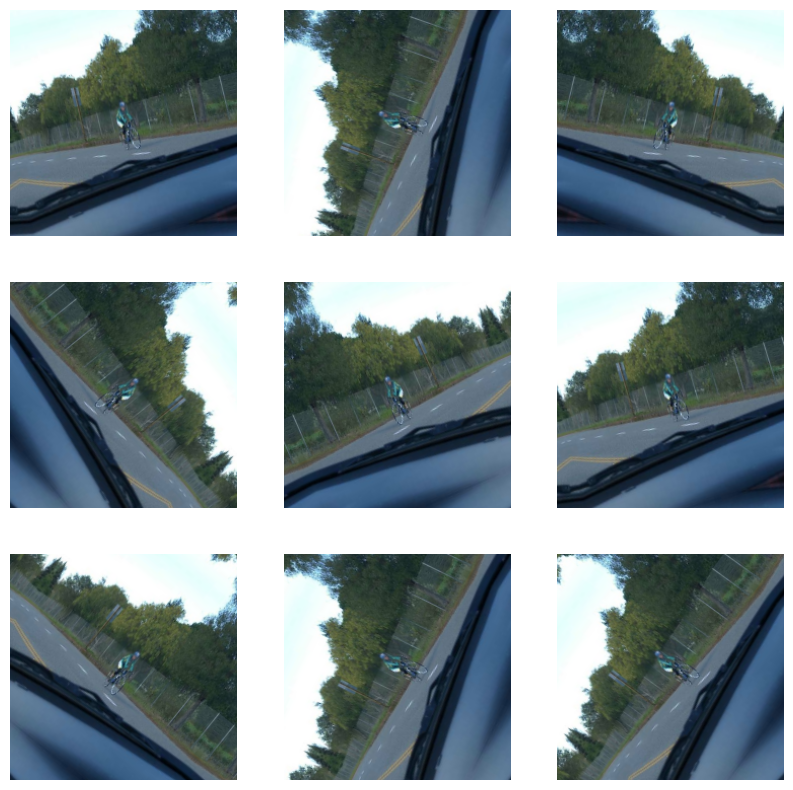

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Creating base model from pretrained ResNet50 on Imagenet dataset

In [ ]:
# Create the base model from the pre-trained model Resnet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

# Freeze the base model
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Update the output layer for multiclass classification
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
dense_layer_512 = tf.keras.layers.Dense(512, activation='relu')
dense_layer_256 = tf.keras.layers.Dense(256, activation='relu')
dense_layer_128 = tf.keras.layers.Dense(128, activation='relu')
outputs = dense_layer_512(feature_batch_average)
outputs = dense_layer_256(outputs)
outputs = dense_layer_128(outputs)
outputs = tf.keras.layers.Dropout(0.2)(outputs)
outputs = prediction_layer(outputs)

# Build the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = dense_layer_512(x)
x = dense_layer_256(x)
x = dense_layer_128(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
len(model.trainable_variables)

8

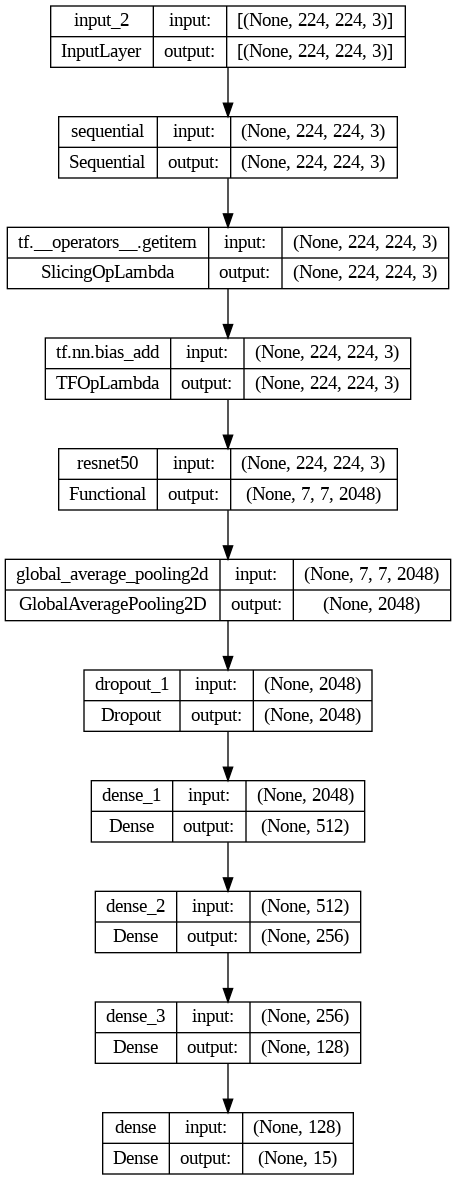

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print("Number of layers in the model: ", len(model.layers))

Number of layers in the model:  11


In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_2 True
1 sequential True
2 tf.__operators__.getitem True
3 tf.nn.bias_add True
4 resnet50 False
5 global_average_pooling2d True
6 dropout_1 True
7 dense_1 True
8 dense_2 True
9 dense_3 True
10 dense True


### Train the model

In [ ]:
initial_epochs = 15

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/15
204/204 [==============================] - 305s 1s/step - loss: 1.3746 - accuracy: 0.5946 - val_loss: 0.5646 - val_accuracy: 0.8290
Epoch 2/15
204/204 [==============================] - 276s 1s/step - loss: 0.6931 - accuracy: 0.7766 - val_loss: 0.3880 - val_accuracy: 0.8930
Epoch 3/15
204/204 [==============================] - 277s 1s/step - loss: 0.5607 - accuracy: 0.8238 - val_loss: 0.3566 - val_accuracy: 0.8868
Epoch 4/15
204/204 [==============================] - 283s 1s/step - loss: 0.4939 - accuracy: 0.8378 - val_loss: 0.3102 - val_accuracy: 0.9065
Epoch 5/15
204/204 [==============================] - 266s 1s/step - loss: 0.4330 - accuracy: 0.8579 - val_loss: 0.2985 - val_accuracy: 0.9016
Epoch 6/15
204/204 [==============================] - 284s 1s/step - loss: 0.4034 - accuracy: 0.8672 - val_loss: 0.2678 - val_accuracy: 0.9164
Epoch 7/15
204/204 [==============================] - 284s 1s/step - loss: 0.3861 - accuracy: 0.8732 - val_loss: 0.2638 - val_accuracy: 0.9127

In [ ]:
model.save('/content/drive/My Drive/Classification/ResNet50.h5')

# Save training history
import json

with open('/content/drive/My Drive/Classification/history_ResNet50.json', 'w') as f:
    json.dump(history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Learning curves

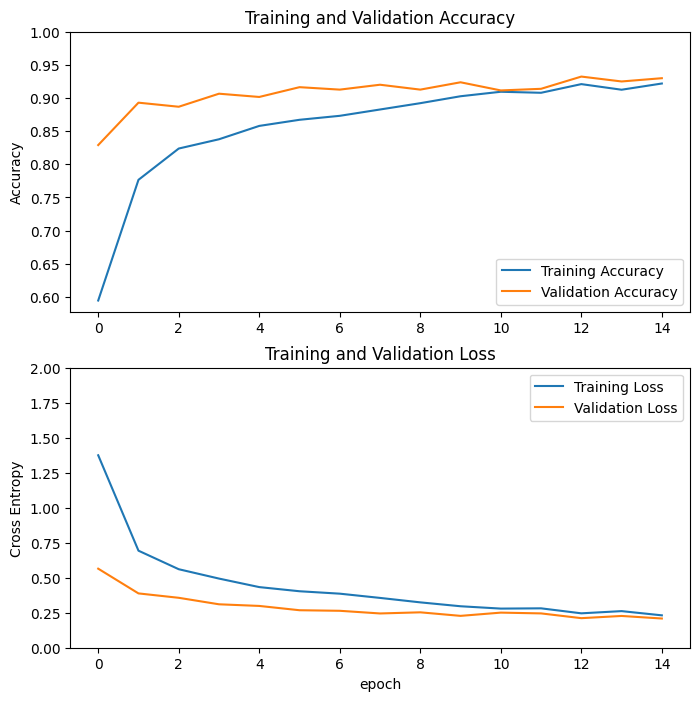

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 123

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


### Compiling the model

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
len(model.trainable_variables)

72

In [ ]:
print("Number of layers in the model: ", len(model.layers))

Number of layers in the model:  11


In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_2 True
1 sequential True
2 tf.__operators__.getitem True
3 tf.nn.bias_add True
4 resnet50 True
5 global_average_pooling2d True
6 dropout_1 True
7 dense_1 True
8 dense_2 True
9 dense_3 True
10 dense True


### Resuming Model Training

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/30
204/204 [==============================] - 286s 1s/step - loss: 0.1985 - accuracy: 0.9367 - val_loss: 0.2170 - val_accuracy: 0.9287
Epoch 16/30
204/204 [==============================] - 271s 1s/step - loss: 0.1631 - accuracy: 0.9468 - val_loss: 0.1643 - val_accuracy: 0.9459
Epoch 17/30
204/204 [==============================] - 288s 1s/step - loss: 0.1412 - accuracy: 0.9531 - val_loss: 0.1562 - val_accuracy: 0.9496
Epoch 18/30
204/204 [==============================] - 290s 1s/step - loss: 0.1229 - accuracy: 0.9593 - val_loss: 0.1271 - val_accuracy: 0.9606
Epoch 19/30
204/204 [==============================] - 308s 1s/step - loss: 0.1028 - accuracy: 0.9665 - val_loss: 0.1471 - val_accuracy: 0.9483
Epoch 20/30
204/204 [==============================] - 285s 1s/step - loss: 0.0920 - accuracy: 0.9697 - val_loss: 0.1284 - val_accuracy: 0.9680
Epoch 21/30
204/204 [==============================] - 286s 1s/step - loss: 0.0819 - accuracy: 0.9739 - val_loss: 0.1213 - val_accuracy:

In [ ]:
model.save('/content/drive/My Drive/Classification/FineTuned_ResNet50.h5')

# Save training history
import json

with open('/content/drive/My Drive/Classification/FineTuned_ResNet50_history.json', 'w') as f:
    json.dump(history.history, f)

### Learning curves after Fine Tuning

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

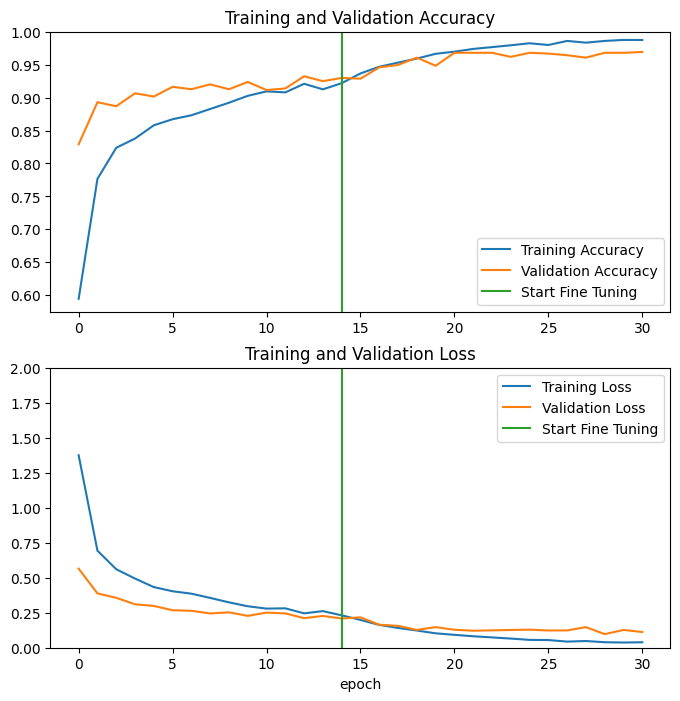

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and Prediction

In [ ]:

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')


26/26 [==============================] - 36s 1s/step - loss: 0.0986 - accuracy: 0.9708
Test Accuracy: 97.08%
Test Loss: 0.09856242686510086


Predictions:
 [13  2  2  1 10 14 13  1  8  6 11  5  0  8  8  2 13  6  8 12  4  5 12  0
  3  0  5 11  0  6  2 11]
Labels:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 

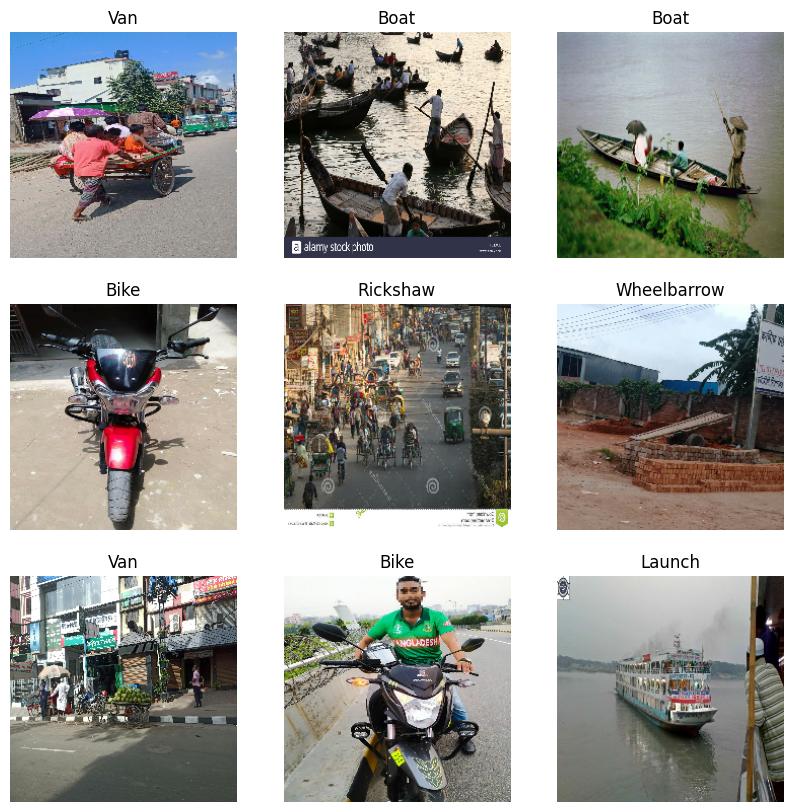

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Convert softmax probabilities to class labels
predicted_classes = tf.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_classes[i]])
    plt.axis("off")


In [ ]:
from sklearn.metrics import classification_report


test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')

# Retrieve true labels and predicted labels for the entire test dataset
true_labels_list = []
predicted_labels_list = []

for image_batch, label_batch in test_dataset.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    predicted_classes = tf.argmax(predictions, axis=1)
    true_labels = np.argmax(label_batch, axis=1)

    true_labels_list.extend(true_labels)
    predicted_labels_list.extend(predicted_classes.numpy())

# Convert lists to numpy arrays
true_labels_array = np.array(true_labels_list)
predicted_labels_array = np.array(predicted_labels_list)

# Compute precision, recall, and f1 score
report = classification_report(true_labels_array, predicted_labels_array, target_names=class_names)
print("Classification Report:\n", report)


26/26 [==============================] - 34s 1s/step - loss: 0.0986 - accuracy: 0.9708
Test Accuracy: 97.08%
Test Loss: 0.09856240451335907
Classification Report:
               precision    recall  f1-score   support

     Bicycle       0.93      0.99      0.96        71
        Bike       0.99      0.97      0.98        87
        Boat       0.97      1.00      0.98        62
         Bus       0.94      1.00      0.97        46
         Car       0.96      0.97      0.97        71
         Cng       0.96      0.96      0.96        54
   Easy-bike       0.95      1.00      0.98        62
  Horse-cart       1.00      0.96      0.98        26
      Launch       1.00      0.97      0.98        67
      Leguna       0.96      1.00      0.98        22
    Rickshaw       1.00      0.92      0.96        50
     Tractor       1.00      0.95      0.98        44
       Truck       1.00      0.92      0.96        73
         Van       0.94      1.00      0.97        62
 Wheelbarrow       1.00  

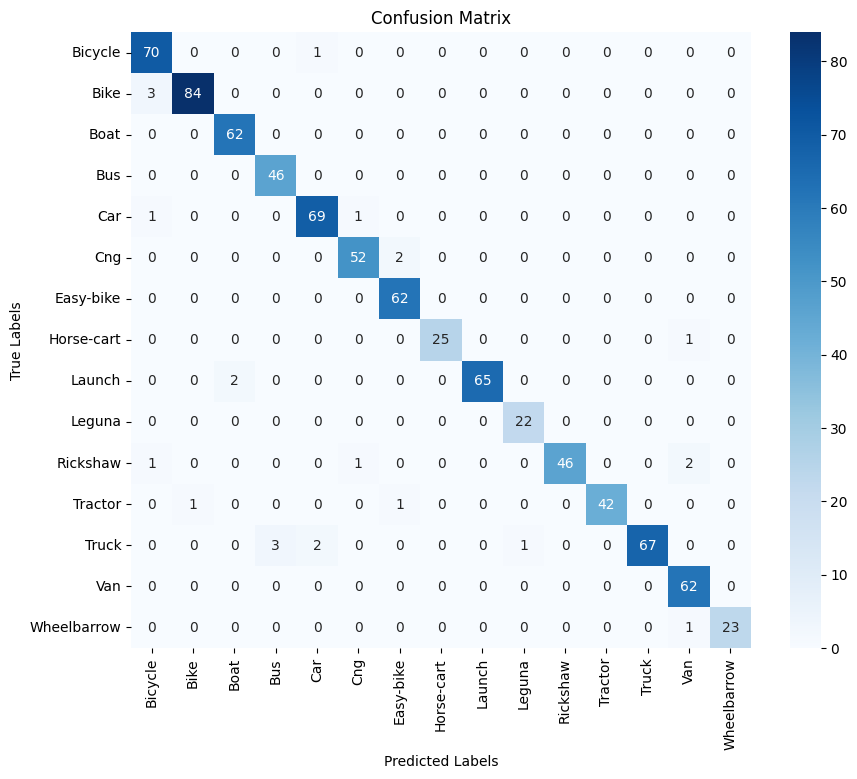

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_array, predicted_labels_array)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
